In [1]:
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction
import numpy as np
import matplotlib.pyplot as plt

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    print(p, '/', l)

# load SE pulse sequence
seq = Sequence(SEQUENCE_DIR+'SE.py')

### Gradient Calibration

To calibrate e.g. the X gradient:
1. Measure the internal diameter of the sample tube and enter it into `SAMPLE_EXTENT` below
2. Set `GRADIENT_DIR` to `(1, 0, 0)` for the X direction
3. Run all cells and read the calibrated gradient value at the end

In [2]:
SAMPLE_EXTENT = 12.9e-3 # sample diameter/height in meters
GRADIENT_DIR = (1, 0, 0) # X direction

In [3]:
# load relevant global variables
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'shims.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')

G_MAG = 0.75 # calibration accuracy is better when not driving gradient amplifiers into saturation

seq.setpar(
    g_read=G_MAG*np.array(GRADIENT_DIR), 
    
    t_dw=1e-6,
    n_samples=1000,
    
    t_echo=2000e-6,
    t_end=0.5,
    n_scans=2
)

# print out the parameter set for reference
print(seq.par)

# run sequence, progress_handler is optional
await seq.run(progress_handler=print_progress);

ParameterSet(n_scans=2, f=15017575.725014996, a_90=0.30345263189396215, t_90=6.4e-05, a_180=0.6520612787332722, t_180=6.4e-05, t_dw=1e-06, n_samples=1000, t_echo=0.002, t_end=0.5, g_read=array([0.75, 0.  , 0.  ]), t_grad_rise=5e-05, shim_x=0.05281809431389152, shim_y=-0.1806430121668586, shim_z=0.09078883324989534, shim_z2=0.2994299533872298, shim_zx=0.024514820487601126, shim_zy=-0.09273833631229139, shim_xy=-0.033636058841420846, shim_x2y2=0.16906828401485402)
1 / 2
2 / 2


G_CAL=0.204 T/m for direction (1, 0, 0)


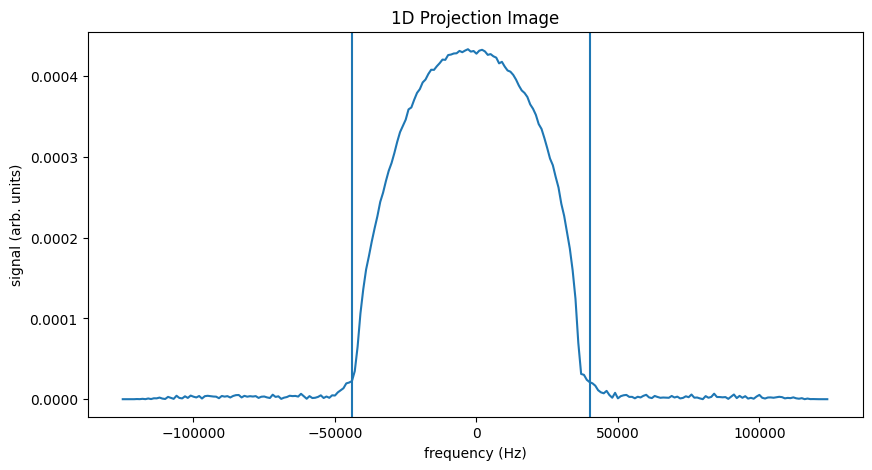

In [5]:
# Decimate for flat filter
DECIMATION = 4
y_dec = decimate(seq.data, DECIMATION)
image = np.fft.fftshift(np.fft.fft(y_dec))
freq = np.fft.fftshift(np.fft.fftfreq(len(image), DECIMATION*seq.par.t_dw))

# Find edges
thresh = 0.05*np.max(np.abs(image))
f1 = None
f2 = None
for f, v in zip(freq, np.abs(image)):
    if v>thresh and f1 is None:
        f1 = f
    if v<thresh and f1 is not None and f2 is None:
        f2 = f
df = f2-f1

GAMMA=42.577e6 # Hz/T
G_CAL = df/GAMMA/SAMPLE_EXTENT/G_MAG
print(f'G_CAL={G_CAL:.3f} T/m for direction {GRADIENT_DIR}')

plt.figure(figsize=(10,5), dpi=100)
plt.plot(freq, np.abs(image))
plt.ylabel('signal (arb. units)')
plt.xlabel('frequency (Hz)')
plt.title('1D Projection Image')
plt.axvline(f1)
plt.axvline(f2)
plt.show()